In [3]:
! export JAX_PLATFORMS=cpu

/gpfs/cfel/group/cmi/common/psi4/psi4conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


# Rotational cluster states of H2S

Here we identify the rotational cluster states of H2S for high $J\sim 50..60$

In [4]:
import itertools
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from PIL import Image

from rovib.symtop import symtop_on_grid

Read pure rotational states of H2S from the HDF5 files, produced by `h2s_rovib.ipynb`, and plot the rotation energy level diagram.

In [5]:
def select_states_vib0(j_angmom: int, pmax: int = 20):
    """Selects states with the (0, 0, 0) assignment for vibrational quanta,
    i.e., rotational states belonging to the ground vibrational state.

    Returns a list of states, where each state is represented as a tuple in the format:
    (rotational quantum number, state index, state energy, state assignment with quanta).
    The `state assignment with quanta` is a list containing the following elements:
        - total symmetry
        - J (rotational quantum number)
        - v1 (vibrational quantum number for mode 1)
        - v2 (vibrational quantum number for mode 2)
        - v3 (vibrational quantum number for mode 3)
        - vibrational symmetry
        - k (rotational quantum number projection on the molecular symmetry axis)
        - tau (rotational parity index)
        - rotational symmetry
    """
    h5 = h5py.File(f"h2s_coefficients_pmax{pmax}_j{j_angmom}.h5", "r")
    energies = []
    energy_ind = []
    quanta = []
    for sym in h5["energies"].keys():
        enr = h5["energies"][sym][:]
        coefs = h5["coefficients"][sym][:]
        qua = np.array(
            [elem[0].decode("utf-8").split(",") for elem in h5["quanta"][sym][:]]
        )
        state_qua = qua[np.argmax(np.abs(coefs) ** 2, axis=0)]
        vib_qua = state_qua[:, 2:5]
        ground_state_ind = np.where(
            (vib_qua[:, 0] == "0") & (vib_qua[:, 1] == "0") & (vib_qua[:, 2] == "0")
        )[0]
        energies.append(enr[ground_state_ind])
        energy_ind.append(ground_state_ind)
        quanta.append(state_qua[ground_state_ind])

    energies = np.concatenate(energies, axis=0)
    energy_ind = np.concatenate(energy_ind, axis=0)
    quanta = np.concatenate(quanta, axis=0)
    ind = np.argsort(energies)
    energies = energies[ind]
    energy_ind = energy_ind[ind]
    quanta = quanta[ind].tolist()
    states = [(j_angmom, i, e, q) for i, e, q in zip(energy_ind, energies, quanta)]
    return states

In [6]:
# use the function above to read all rotational states up to J=60

max_j = 60
rot_states = {}
for j_angmom in range(max_j):
    rot_states[j_angmom] = select_states_vib0(j_angmom)

Plot rotational states. To be able to observe the clustering effect, for each $J$ we subtract the uppermost energy $E_{J,k,\tau}^\text{(max)}$ from all the energy levels lying below.

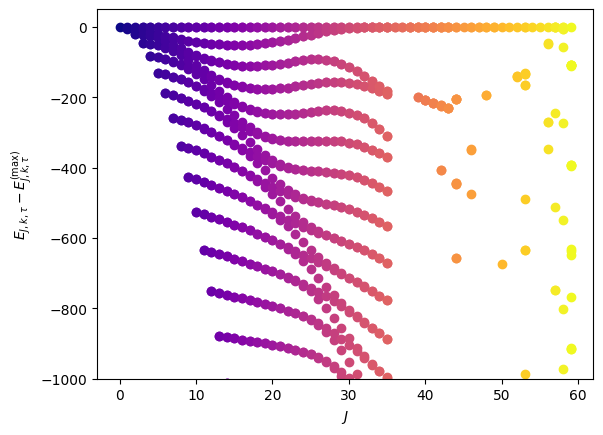

In [7]:
max_j = max(list(rot_states.keys()))
for j_angmom, states in rot_states.items():
    # subtract the highest state energy (list is sorted wrt energy)
    upper_enr = states[-1][2]
    enr = [state[2] - upper_enr for state in states]
    plt.scatter([j_angmom for _ in range(len(enr))], enr, color=cm.plasma(j_angmom / max_j))

plt.xlabel("$J$")
plt.ylabel("$E_{J,k,\\tau}-E_{J,k,\\tau}^\\text{(max)}$")
plt.ylim([-1000, 50])
plt.show()

From the plot, it's clear that the state assignments by vibrational quanta are incorrect for states with $J>35$. This indicates contributions to the vibrational ground state from excited vibrational states, which ultimately cause the rotational clustering effect.

To identify which states form clusters, we can plot the rotational density for a subset of states preselected as potential candidates and visually inspect these plots.

First, let's fit the energy of cluster states for $J=0..35$ using a simple function $E_{J,k,\tau}^\text{max}=BJ(J+1)$. With this function, we can estimate the upper bound for the cluster state energy for states with $J>35$.

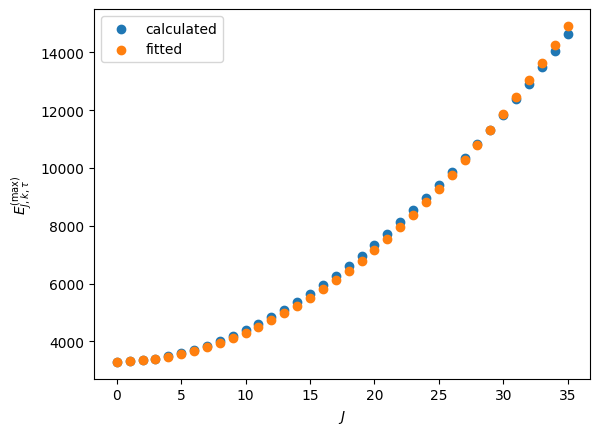

In [8]:
upper_enr = np.array(
    [states[-1][2] for j, states in rot_states.items() if j <= 35]
)
j_list = np.array([j for j in rot_states.keys() if j <= 35])

zpe = upper_enr[0]
b_const_upper = np.sum((upper_enr-zpe) * j_list * (j_list+1) ) / np.sum(
    j_list**2 * (j_list +1)**2
)
upper_enr_func = lambda j: zpe + b_const_upper * j * (j+1)

plt.scatter(j_list, upper_enr, label="calculated")
plt.scatter(j_list, [upper_enr_func(j) for j in j_list], label="fitted")
plt.xlabel("$J$")
plt.ylabel("$E_{J,k,\\tau}^\\text{(max)}$")
plt.legend()
plt.show()

Next, preselect sets of states for each $J=36..60$ that are four-fold nearly-degenerate with symmetries $A_1$, $B_1$, $A_2$, and $B_2$
and lie within the specified energy range. The maximum energy is estimated using the fitted $BJ(J+1)$ function, while the minimum is determined by the energy of the cluster state with $J$ one unit smaller than the current value.

In [9]:
def select_cluster_states(
    j_angmom: int, lower_enr: float, upper_enr: float, pmax: int = 20, tol: float = 1e-3
):
    """Selects sets of states as possible candidates for rotational cluster states,
    based of four-fold degeneracy of states with symmetries A1, A2, B1, and B2
    """
    h5 = h5py.File(f"h2s_coefficients_pmax{pmax}_j{j_angmom}.h5", "r")
    energies = []
    symmetries = []
    energy_ind = []
    quanta = []
    for sym in h5["energies"].keys():
        enr = h5["energies"][sym][:]
        coefs = h5["coefficients"][sym][:]
        qua = np.array(
            [elem[0].decode("utf-8").split(",") for elem in h5["quanta"][sym][:]]
        )
        energies.append(enr)
        symmetries.append([sym for _ in range(len(enr))])
        energy_ind.append([i for i in range(len(enr))])
        quanta.append(qua[np.argmax(np.abs(coefs) ** 2, axis=0)])

    energies = np.concatenate(energies, axis=0)
    symmetries = np.concatenate(symmetries, axis=0)
    energy_ind = np.concatenate(energy_ind, axis=0)
    quanta = np.concatenate(quanta, axis=0)
    ind = np.argsort(energies)
    energies = energies[ind]
    symmetries = symmetries[ind]
    energy_ind = energy_ind[ind]
    quanta = quanta[ind]

    cluster_states = []
    for i in range(len(energies) - 4):
        enr_list = energies[i : i + 4]
        sym_list = symmetries[i : i + 4]
        qua = quanta[i : i + 4].tolist()
        enr_ind = energy_ind[i : i + 4]
        # cluster-states conditions
        if (
            np.all(enr_list >= lower_enr)
            and np.all(enr_list <= upper_enr)
            and np.all(np.abs(enr_list - enr_list[0]) < tol)
            and ",".join(sorted(sym_list)) == "A1,A2,B1,B2"
        ):
            cluster_states.append(
                [(j_angmom, i, e, q) for i, e, q in zip(enr_ind, enr_list, qua)]
            )
    return cluster_states

In [10]:
# use the above function to preselect states that can be cluster states

min_j = 36
max_j = 60
lower_enr = rot_states[min_j - 1][-1][2]
cluster_states = {}
for j_angmom in range(min_j, max_j + 1):
    upper_enr = upper_enr_func(j_angmom)
    print(f"J = {j_angmom}, lower energy estimate = {lower_enr}, upper energy estimate = {upper_enr}")
    cluster_states[j_angmom] = select_cluster_states(
        j_angmom=j_angmom, lower_enr=lower_enr, upper_enr=upper_enr, tol=1
    )
    lower_enr = cluster_states[j_angmom][0][0][2]
    for state in cluster_states[j_angmom]:
        print(state)

J = 36, lower energy estimate = 14641.144572867164, upper energy estimate = 15578.67185281825
[(36, 71, 15239.31670863414, ['B2', '36', '0', '0', '0', 'A1', '29', '0', 'B2']), (36, 61, 15239.316709600369, ['A2', '36', '0', '0', '0', 'A1', '29', '1', 'A2']), (36, 72, 15239.45264848649, ['A1', '36', '0', '0', '0', 'A1', '30', '0', 'A1']), (36, 61, 15239.452699713995, ['B1', '36', '0', '0', '0', 'A1', '30', '1', 'B1'])]
[(36, 71, 15462.586624981224, ['B1', '36', '1', '0', '2', 'B2', '11', '1', 'A2']), (36, 71, 15462.586624981483, ['A2', '36', '1', '0', '2', 'B2', '12', '1', 'B1']), (36, 79, 15462.904311937129, ['A1', '36', '1', '0', '3', 'A1', '2', '0', 'A1']), (36, 77, 15462.904311937406, ['B2', '36', '1', '0', '3', 'A1', '1', '0', 'B2'])]
J = 37, lower energy estimate = 15239.31670863414, upper energy estimate = 16261.311388288017
[(37, 60, 15433.629300120063, ['B1', '37', '0', '0', '4', 'A1', '6', '1', 'B1']), (37, 60, 15433.629300398137, ['A2', '37', '0', '0', '4', 'A1', '5', '1', 'A2

Finally, to identify the highest-energy cluster states withing the ground vibrational state, plot rotational densities for all cluster-state candidates for different $J$ quanta and select the correct states by visually ispeciting these density images. 

In [19]:
def psi_on_grid(
    j_angmom: int,
    sym: str,
    state_ind: int,
    euler_grid,
    m_angmom: int = None,
    pmax: int=20,
):
    """Computes rovibrational function for selected state on grid of Euler angles"""
    if m_angmom is None:
        m_angmom = j_angmom

    # precompute symmetric-top functions in Wang's representation
    psi_rot, _, jktau_list = symtop_on_grid(j_angmom, euler_grid)
    m_ind = [m for m in range(-j_angmom, j_angmom + 1)].index(m_angmom)
    psi_rot = psi_rot[m_ind, :, :]

    h5 = h5py.File(f"h2s_coefficients_pmax{pmax}_j{j_angmom}.h5", "r")
    enr = h5["energies"][sym][state_ind]
    coefs = h5["coefficients"][sym][:, state_ind]
    qua = np.array(
        [elem[0].decode("utf-8").split(",") for elem in h5["quanta"][sym][:]]
    )
    vib_qua = qua[:, 2:6]
    rot_qua = qua[:, 6:9]

    # compute rotational part for all basis functions
    ktau_ind = [
        np.where(
            (jktau_list[:, 0] == str(j_angmom))
            & (jktau_list[:, 1] == k)
            & (jktau_list[:, 2] == tau)
        )[0][0]
        for (k, tau) in rot_qua[:, :2]
    ]
    psi = psi_rot[ktau_ind,:]

    # unique set of vibrational quanta
    vib_qua_unique = np.unique(vib_qua, axis=0)
    v_ind = [
        np.where(
            (vib_qua[:, 0] == v1)
            & (vib_qua[:, 1] == v2)
            & (vib_qua[:, 2] == v3)
            & (vib_qua[:, 3] == vsym)
        )[0]
        for (v1, v2, v3, vsym) in vib_qua_unique
    ]
    unique_vec = np.zeros((len(qua), len(vib_qua_unique)))
    for i, v in enumerate(v_ind):
        unique_vec[v, i] = 1

    psi_rovib = np.einsum("i,ig,iu->ug", coefs, psi, unique_vec, optimize="optimal")
    return psi_rovib, enr

In [20]:
def store_density_file(
    j_angmom: int,
    sym: str,
    state_ind: int,
    euler_grid,
    euler_mesh,
    filename: str,
    title: str,
):
    """Plots the rotational density as function of Euler angles beta and gamma
    and stores it in file. To be used for visual identification of rotational cluster states.
    """
    psi, enr = psi_on_grid(
        j_angmom=j_angmom, sym=sym, state_ind=state_ind, euler_grid=euler_grid
    )
    dens = np.real(np.sum(np.conj(psi) * psi, axis=0)) * np.sin(euler_grid[:, 1])

    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_subplot(projection="3d")
    ax.set_box_aspect(aspect=(1, 1, 1))
    ax.axes.set_xlim3d(left=-1.5, right=1.5)
    ax.axes.set_ylim3d(bottom=-1.5, top=1.5)
    ax.axes.set_zlim3d(bottom=-1.5, top=1.5)

    theta, phi = euler_mesh
    npoints = len(theta)
    d = dens.reshape(npoints, -1).T
    r = d / np.max(d) + 1
    r = r.reshape(npoints, -1)
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    ax.plot_surface(x, y, z, facecolors=cm.jet(r / np.amax(r)), rstride=1, cstride=1)
    plt.title(title)
    plt.savefig(filename)
    plt.close()


def stack_images(image_files, output_file):
    images = [Image.open(image_file) for image_file in image_files]
    widths, heights = zip(*(img.size for img in images))
    stacked_image = Image.new("RGB", (max(widths), sum(heights)))
    y_offset = 0
    for img in images:
        stacked_image.paste(img, (0, y_offset))
        y_offset += img.height
    stacked_image.save(output_file)

In [21]:
# create small grid of Euler angles beta and gamma (fix alpha angle to 0)
npoints = 60
alpha = [0]
beta = np.linspace(0, np.pi, npoints)
gamma = np.linspace(0, 2 * np.pi, npoints)
euler_grid = np.array([elem for elem in itertools.product(alpha, beta, gamma)])
mesh = np.meshgrid(beta, gamma)

# using the functions in the two cells above,
# generate densities for different cluster state candidates
# and store them in one file for every J quanta

for j_angmom in cluster_states.keys():
    no_candidates = len(cluster_states[j_angmom])
    file_list = []
    for icand in range(no_candidates):
        sym = cluster_states[j_angmom][icand][0][3][0]
        state_ind = cluster_states[j_angmom][icand][0][1]
        title = f"({j_angmom}, {sym}, {state_ind})"
        filename = f"dens_{j_angmom}_{icand}.png"
        store_density_file(j_angmom, sym, state_ind, euler_grid, mesh, filename, title)
        file_list.append(filename)
    stack_images(file_list, f"etc/density_assignment/stack_dens_j{j_angmom}.png")
    for filename in file_list:
        os.remove(filename)

Create a list of state indices for all cluster states (uppermost energy states for each $J$ multiplet) for $J=0..60$ and plot rotational energy level diagram

In [8]:
# identify symmetry and id of the lowest energy cluster state for each J=36..60
#   by visually inspecting files with density plots, generated by running the previous cell

cluster_state_ind = {
    36: [("B2", 71)],
    37: [("A1", 70)],
    38: [("B2", 87)],
    39: [("A1", 85)],
    40: [("B2", 104)],
    41: [("A1", 101)],
    42: [("B2", 129)],
    43: [("B1", 146)],
    44: [("A2", 145)],
    45: [("B1", 174)],
    46: [("A2", 170)],
    47: [("A2", 208)],
    48: [("B2", 228)],
    49: [("A1", 224)],
    50: [("B2", 277)],
    51: [("A1", 267)],
    52: [("B2", 324)],
    53: [("A1", 316)],
    54: [("B2", 385)],
    55: [("A1", 371)],
    56: [("B2", 447)],
    57: [("A1", 432)],
    58: [("B2", 520)],
    59: [("A1", 503)],
    60: [("B1", 542)],
}

max_j = max(list(rot_states.keys()))
for j_angmom, states in rot_states.items():
    if j_angmom <= 35:
        cluster_state_ind[j_angmom] = [(states[-1][3][0], states[-1][1])]

Based on the indices of the uppermost-energy rotational states for each $J$, identify their energies together with the other states that belong to the four-fold clusters.

In [9]:
def select_cluster_states_id(j_angmom: int, sym_ind, pmax: int = 20):
    """Selects sets of cluster states based on the four-fold degeneracy
    and symmetry and id number of the lowest state in the cluster group
    """
    h5 = h5py.File(f"h2s_coefficients_pmax{pmax}_j{j_angmom}.h5", "r")
    energies = []
    symmetries = []
    energy_ind = []
    quanta = []
    for sym in h5["energies"].keys():
        enr = h5["energies"][sym][:]
        coefs = h5["coefficients"][sym][:]
        qua = np.array(
            [elem[0].decode("utf-8").split(",") for elem in h5["quanta"][sym][:]]
        )
        energies.append(enr)
        symmetries.append([sym for _ in range(len(enr))])
        energy_ind.append([i for i in range(len(enr))])
        # quanta.append(qua[np.argmax(np.abs(coefs) ** 2, axis=0)[0]])
        quanta.append(qua[np.argmax(np.abs(coefs) ** 2, axis=0)])

    energies = np.concatenate(energies, axis=0)
    symmetries = np.concatenate(symmetries, axis=0)
    energy_ind = np.concatenate(energy_ind, axis=0)
    quanta = np.concatenate(quanta, axis=0)
    ind = np.argsort(energies)
    energies = energies[ind]
    symmetries = symmetries[ind]
    energy_ind = energy_ind[ind]
    quanta = quanta[ind]

    cluster_states = []
    for i in range(len(energies) - 4):
        enr_list = energies[i : i + 4]
        sym_list = symmetries[i : i + 4]
        qua = quanta[i : i + 4].tolist()
        enr_ind = energy_ind[i : i + 4]
        # cluster-states conditions
        if any([enr_ind[0] == i and sym_list[0] == s for (s, i) in sym_ind]):
            cluster_states.append(
                [(j_angmom, i, e, q) for i, e, q in zip(enr_ind, enr_list, qua)]
            )
    return cluster_states

In [10]:
# run the above function to extract all states components of degenerate clusters
#   and store data in file

cluster_states = {}
for j_angmom, sym_ind_list in cluster_state_ind.items():
    cluster_states[j_angmom] = select_cluster_states_id(j_angmom, sym_ind_list)
    for states in cluster_states[j_angmom]:
        print(states)

with open("h2s_cluster_states_id.txt", "w") as fl:
    for j_angmom, state in cluster_states.items():
        cluster_group = state[0]
        fl.write(
            "   ".join(
                f"{j:3d} {id:6d} {e:20.10f}" + " ".join(f" {q}" for q in qua)
                for (j, id, e, qua) in cluster_group
            )
            + "\n"
        )

[(36, 71, 15239.31670863414, ['B2', '36', '0', '0', '0', 'A1', '29', '0', 'B2']), (36, 61, 15239.316709600369, ['A2', '36', '0', '0', '0', 'A1', '29', '1', 'A2']), (36, 72, 15239.45264848649, ['A1', '36', '0', '0', '0', 'A1', '30', '0', 'A1']), (36, 61, 15239.452699713995, ['B1', '36', '0', '0', '0', 'A1', '30', '1', 'B1'])]
[(37, 70, 15849.750380002451, ['A1', '37', '0', '0', '0', 'A1', '30', '0', 'A1']), (37, 78, 15849.750380657222, ['B1', '37', '0', '0', '0', 'A1', '30', '1', 'B1']), (37, 78, 15849.823189790066, ['A2', '37', '0', '0', '0', 'A1', '29', '1', 'A2']), (37, 72, 15849.823189839546, ['B2', '37', '0', '0', '0', 'A1', '29', '0', 'B2'])]
[(38, 87, 16471.845256919318, ['B2', '38', '0', '0', '0', 'A1', '31', '0', 'B2']), (38, 75, 16471.84525744378, ['A2', '38', '0', '0', '0', 'A1', '31', '1', 'A2']), (38, 75, 16471.883673568496, ['B1', '38', '0', '0', '0', 'A1', '30', '1', 'B1']), (38, 89, 16471.883673576616, ['A1', '38', '0', '0', '0', 'A1', '30', '0', 'A1'])]
[(39, 85, 17105.

Plot the energies of cluster states

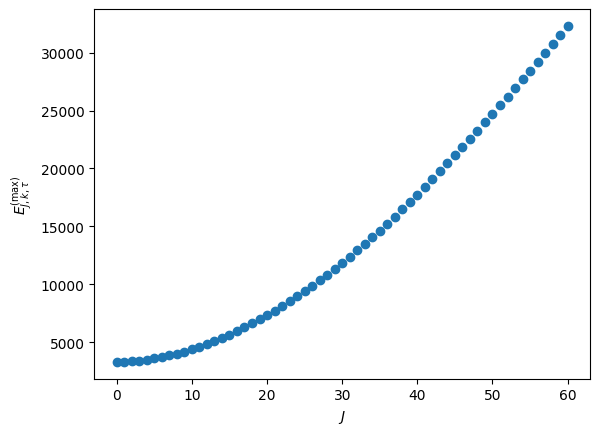

In [11]:
j_list = [j for j in cluster_states.keys()]
enr_list = [elem[0][0][2] for elem in cluster_states.values()]
plt.scatter(j_list, enr_list)
plt.xlabel("$J$")
plt.ylabel("$E_{J,k,\\tau}^\\text{(max)}$")
plt.show()

Just for plotting of the rotational energy level diagram, we may select again rotational states based on the leading contribution from the pure vibrational state but also considering states for which the pure vibrational state enters as the second, third, or fourth leading contribution.

In [12]:
def select_states_vib0_ext(j_angmom: int, pmax: int = 20):
    """Selects states with the (0, 0, 0) assignment for vibrational quanta,
    where (0, 0, 0 ) corresponds to the first, second, third, or fourth leading contribution.
    """
    h5 = h5py.File(f"h2s_coefficients_pmax{pmax}_j{j_angmom}.h5", "r")
    energies = []
    energy_ind = []
    quanta = []
    for sym in h5["energies"].keys():
        enr = h5["energies"][sym][:]
        coefs = h5["coefficients"][sym][:]
        qua = np.array(
            [elem[0].decode("utf-8").split(",") for elem in h5["quanta"][sym][:]]
        )
        for i in range(4): # first, second, third, or fourth largest contribuions from (0,0,0)
            state_qua = qua[np.argmax(np.abs(coefs) ** 2, axis=0)]
            vib_qua = state_qua[:, 2:5]
            ground_state_ind = np.where(
                (vib_qua[:, 0] == "0") & (vib_qua[:, 1] == "0") & (vib_qua[:, 2] == "0")
            )[0]
            energies.append(enr[ground_state_ind])
            energy_ind.append(ground_state_ind)
            quanta.append(state_qua[ground_state_ind])
            max_ind = np.argmax(np.abs(coefs) ** 2, axis=0)
            for i in range(coefs.shape[-1]):
                coefs[max_ind[i], i] = 0

    energies = np.concatenate(energies, axis=0)
    energy_ind = np.concatenate(energy_ind, axis=0)
    ind = np.argsort(energies)
    energies = energies[ind]
    energy_ind = energy_ind[ind]
    states = [(j_angmom, i, e) for i, e in zip(energy_ind, energies)]
    return states

In [13]:
# select states using the function above

max_j = 60
rot_states_ext = {}
for j_angmom in range(max_j):
    rot_states_ext[j_angmom] = select_states_vib0_ext(j_angmom)

In [21]:
with open('cluster_states_plot.txt','w') as fl:
    for j_angmom, states in rot_states_ext.items():
        if j_angmom <= 35:
            upper_enr = rot_states[j_angmom][-1][2]
        else:
            upper_enr = cluster_states[j_angmom][0][0][2]
        enr = [state[2] - upper_enr for state in states]
        out_str = f"{j_angmom}" + " " + " ".join("%20.10f"%e for e in enr)
        fl.write(out_str + "\n")

In [17]:
# plot rotational energy level diagram

# import matplotlib
# matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# matplotlib.rc('text', usetex=True)

max_j = max(list(rot_states_ext.keys()))
for j_angmom, states in rot_states_ext.items():
    # subtract the highest state energy (list is sorted wrt energy)
    if j_angmom <= 35:
        upper_enr = rot_states[j_angmom][-1][2]
    else:
        upper_enr = cluster_states[j_angmom][0][0][2]
    enr = [state[2] - upper_enr for state in states]
    plt.scatter(
        [j_angmom for _ in range(len(enr))], enr, color=cm.plasma(j_angmom / max_j)
    )

plt.xlabel("$J$")
plt.ylabel("$E_{J,k,\\tau}-E_{J,k,\\tau}^\\text{(max)}$")
plt.ylim([-1000, 50])
plt.xlim([0, 50])
plt.show()

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp2r02eztl 7047aaa5111e4d8dda9c547b5b45d07c.tex

This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./7047aaa5111e4d8dda9c547b5b45d07c.tex
LaTeX2e <2020-10-01> patch level 4
L3 programming layer <2021-02-18>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2020/04/10 v1.4m Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/helvet.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.8 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmp2r02eztl/7047aaa5111e4d8dda9c547b5b45d07c.log.




<Figure size 640x480 with 1 Axes>

Plot rotational density for some cluster states

In [15]:
npoints = 200
alpha = [0]
beta = np.linspace(0, np.pi, npoints)
gamma = np.linspace(0, 2 * np.pi, npoints)
euler_grid = np.array([elem for elem in itertools.product(alpha, beta, gamma)])
euler_mesh = np.meshgrid(beta, gamma)

In [11]:
# psi, enr = psi_on_grid(20, 50, 50, "B2", 277, grid3d)
psi, enr = psi_on_grid(20, 50, 50, "B2", 516, euler_grid)
dens = np.real(np.sum(np.conj(psi) * psi, axis=0)) * np.sin(grid3d[:,1])
print(enr)

26642.482303239183


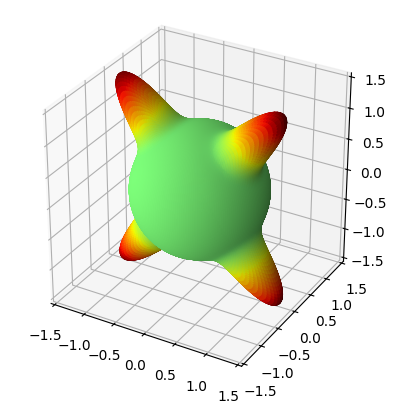

In [32]:

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.set_box_aspect(aspect=(1, 1, 1))
ax.axes.set_xlim3d(left=-1.5, right=1.5)
ax.axes.set_ylim3d(bottom=-1.5, top=1.5)
ax.axes.set_zlim3d(bottom=-1.5, top=1.5)

d = dens.reshape(npoints, -1).T
r = d / np.max(d) + 1
r = r.reshape(npoints, -1)

theta, phi = mgrid
x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)
ax.plot_surface(x, y, z, facecolors=cm.plasma(r / np.amax(r)), rstride=1, cstride=1)